In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on GPU')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Running on CPU')

Running on GPU
Tesla T4


In [5]:
train_dataset = torchvision.datasets.CIFAR10(root = './cifar10', transform = torchvision.transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, transform=torchvision.transforms.ToTensor())

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [8]:
#dataloader class majjes it easy for us to handle and customize data
#train and test loader both have 128 size batches of images, are shuffled to increase randomization
train_loader = torch.utils.data.DataLoader(train_dataset, 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, 128, shuffle = True)

torch.Size([3, 32, 32])


<function matplotlib.pyplot.show(close=None, block=None)>

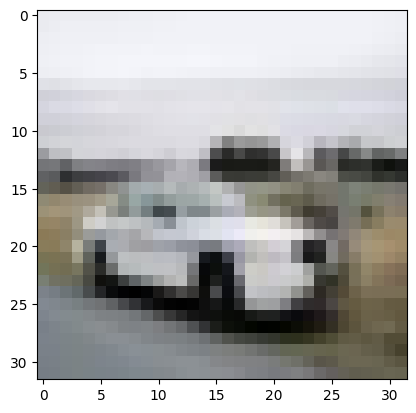

In [11]:
#visualizing a sample from train loader
train_iter = iter(train_loader)
batch_images, batch_labels = next(train_iter)

image, label = batch_images[0], batch_labels[0]
print(image.shape)
plt.imshow(image.permute(1,2,0)) #permutate so that that it is converted from pytorch to smth matplot lib canr ead
plt.show

In [81]:
#training CNN Class
#nn.Conv2d(input_channels, out_channels, kernel_size=, padding=, stride=)
#input_chennels = 3 (becuase red green and blue)
#out_channels = 1

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    #first convolutional layer
    # defining a standard kayer with convolution, batchnorm and dropout
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.relu1=nn.ReLU()
    self.dropout1 = nn.Dropout(0.1) # very first layer is supposed to generalise more and therefore higher drop out rate

    #second convolution layer
    self.conv2 =  nn.Conv2d(32, 64, kernel_size = 3, padding=1, stride=2)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2,2) #adding a pooling layer to reduce spatial dimensions
    self.dropout2 = nn.Dropout(0.05) #lower from here onwards to learn the specific features

    #third convolution later
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2)
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(0.05)
    self.flatten = nn.Flatten()

    #fully connected layer - classifying the features into 10 classes
    self.fc = nn.Linear(64*2*2, 128) #64 from the last conv later, 10 for the number of classes, b x (64*4*4) , 128 is the output size and not the batch size
    self.relu4 = nn.ReLU()
    self.fc1 = nn.Linear(128,10)

  def forward(self,x):
    #Describing the forward pass through the network
    # first conv
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.relu1(x)
    x = self.dropout1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = self.dropout2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = self.relu3(x)
    x = self.dropout3(x)

    x = self.flatten(x)
    x = self.fc(x)
    x = self.relu4(x)
    x = self.fc1(x)

    return x



In [82]:
#creating an instance of our CNN model, after which we load model to
#the device either GPU or CPU
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.05, inplace=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.05, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=128, bias=True)
  (relu4): ReLU()
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [83]:
#This is where we dfine our loss, in this case the loss is cross entropy
#loss is a number that tells our model how good its doing
criterian = nn.CrossEntropyLoss()

In [84]:
#the model.paramters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay = 1e-5)

In [85]:
#training loop, will take the model, train loder , the optimizer and deivce
#loops through each trainng data and trains the model
#Note: the data is loaded in batches and not single instances
def train_one_epoch(model, train_loader, optimizer, criterion, device):
  model.train()
  for i, batch in tqdm(enumerate(train_loader)): #looping through
    inputs, labels = batch #the batch contains the inputs and labels
    inputs = inputs.to(device)
    labels = labels.to(device)

    #get the model output
    outputs = model(inputs)
    #calculate the loss (using criterion defined above)
    loss = criterion(outputs, labels)
    #call loss.backward - this coputes the gradients
    loss.backward()
    #step forward with the optimizer and then zero out the gradients.
    optimizer.step()
    optimizer.zero_grad()

  print('End of epoch loss: ', round(loss.item(),3))

In [86]:
@torch.no_grad()
def test(model, test_loader, device):
  #manually specified the lasses from the cifar-10 dataset
  classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  model.eval()
  correct = 0
  for i, batch in tqdm(enumerate(test_loader)):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    predictions = outputs.argmax(dim = 1)
    correct += (predictions == labels).sum().item()

  print(f"Enf of epoch accuracy: {100 * correct / len(test_dataset)}%")

  #visualizing the current model's performance
  for i in range(min(len(inputs), 8)):
    print('Guess: ', classes[predictions[i]], '| Label:', classes[labels[i]])
    plt.imshow(inputs[i].cpu().permute(1,2,0))
    plt.show()

Epoch:  1


0it [00:00, ?it/s]

End of epoch loss:  1.292


0it [00:00, ?it/s]

Enf of epoch accuracy: 57.13%
Guess:  truck | Label: truck


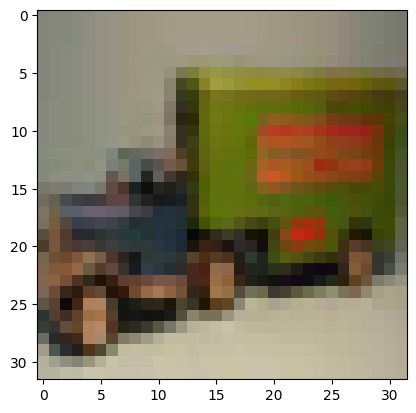

Guess:  horse | Label: horse


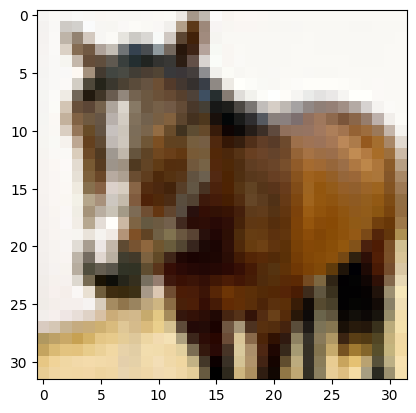

Guess:  frog | Label: bird


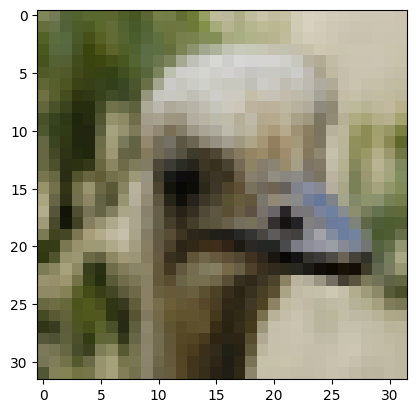

Guess:  horse | Label: horse


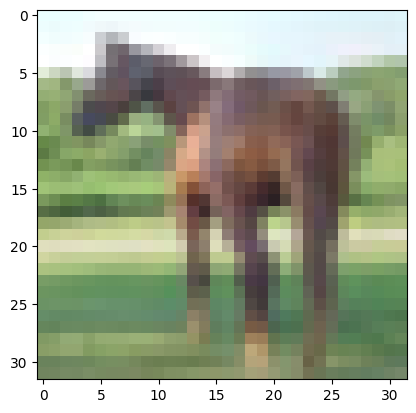

Guess:  frog | Label: frog


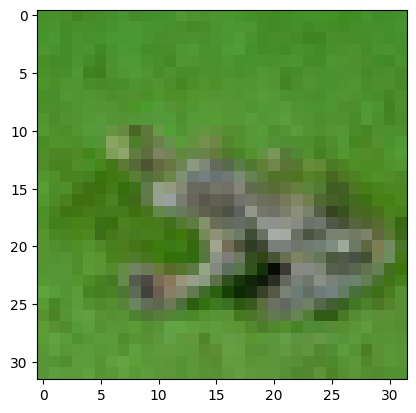

Guess:  frog | Label: cat


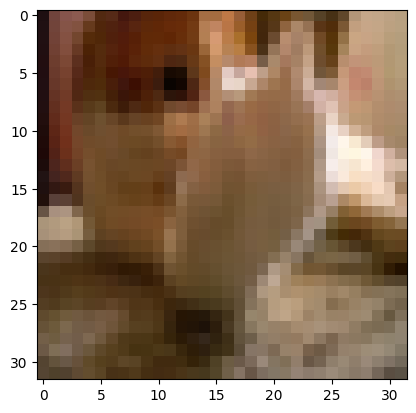

Guess:  cat | Label: cat


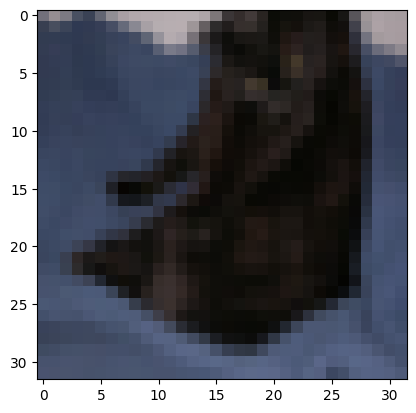

Guess:  ship | Label: plane


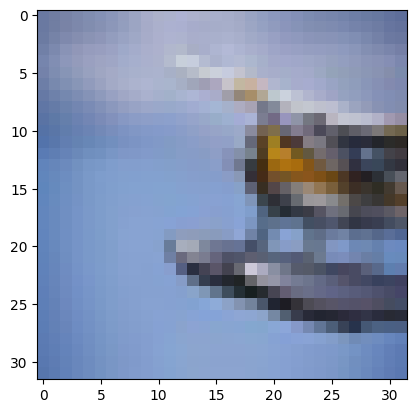

Epoch:  2


0it [00:00, ?it/s]

End of epoch loss:  1.038


0it [00:00, ?it/s]

Enf of epoch accuracy: 55.03%
Guess:  ship | Label: car


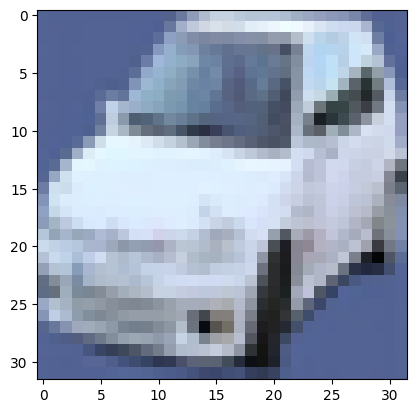

Guess:  truck | Label: truck


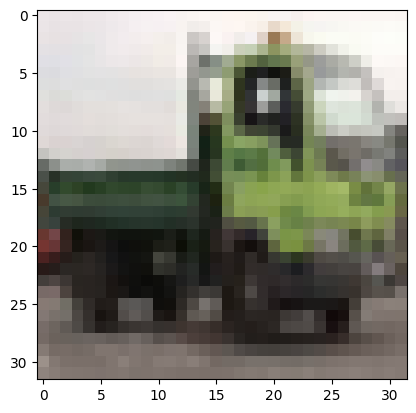

Guess:  bird | Label: horse


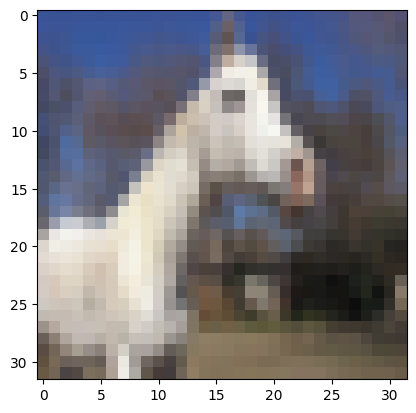

Guess:  plane | Label: bird


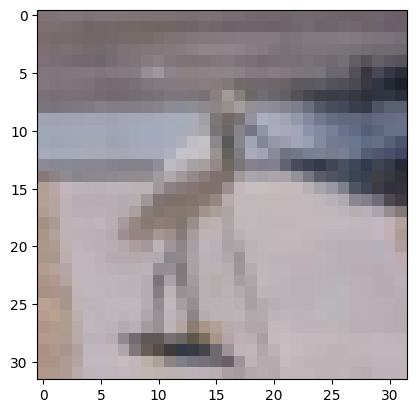

Guess:  cat | Label: cat


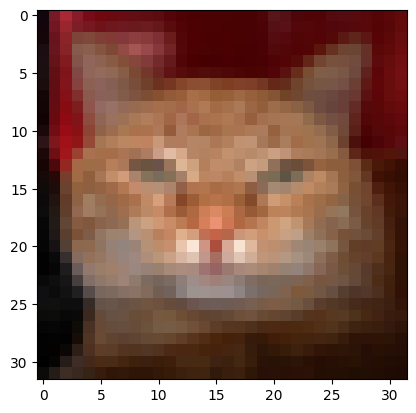

Guess:  frog | Label: frog


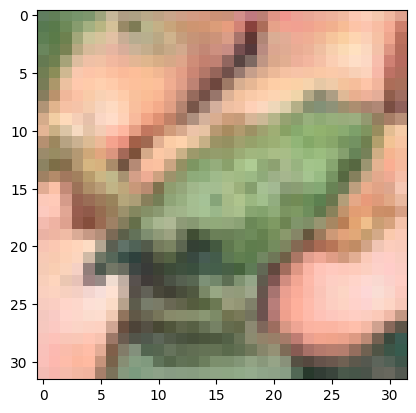

Guess:  plane | Label: plane


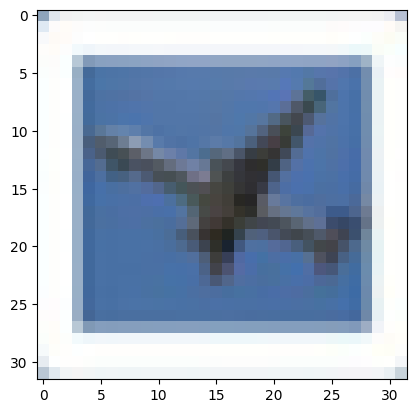

Guess:  dog | Label: cat


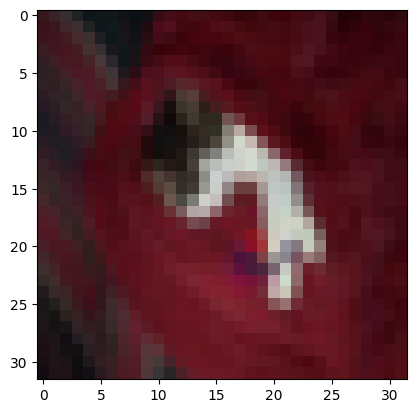

In [87]:
#This is where the training and testing loop is called
NUM_EPOCHS = 2 #one epoch is one loop through the training data

for epoch in range(NUM_EPOCHS):
  print('Epoch: ', epoch+1)
  train_one_epoch(model, train_loader, optimizer, criterian, device)
  test(model, test_loader, device)